In [1]:
import sys

sys.path.append('../')
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from src.ewenpyomo import ewen_model
from src.neural_network import create_nn, data_scaling
from src.omlt_model import create_model


'_BlockData'. The class '_BlockData' has been renamed to 'BlockData'.
(deprecated in 6.7.2) (called from
c:\Users\mexis\anaconda3\envs\main\lib\site-packages\omlt\block.py:33)


__OMLT__

In [6]:
# Data loading
df = pd.read_csv('../data/datasetcost_v2.csv')

# Modeling using ONLY the TOTALA COST
df.drop(columns=['Cost1', 'Cost2', 'Cost3'], inplace=True)

inputs = list(df.columns)
inputs.remove('totalcost')
outputs = ['totalcost']

print(f'Dataset shape: {df.shape}')

Dataset shape: (9933, 7)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Epoch 1/200

104/104 - 1s - loss: 0.9351 - val_loss: 0.8317 - 1s/epoch - 14ms/step
Epoch 2/200
104/104 - 0s - loss: 0.5358 - val_loss: 0.2464 - 316ms/epoch - 3ms/step
Epoch 3/200
104/104 - 0s - loss: 0.1831 - val_loss: 0.1567 - 323ms/epoch - 3ms/step
Epoch 4/200
104/104 - 0s - loss: 0.1570 - val_loss: 0.1516 - 310ms/epoch - 3ms/step
Epoch 5/200
104/104 - 0s - loss: 0.1533 - val_loss: 0.1481 - 317ms/epoch - 3ms/step
Epoch 6/200
104/104 - 0s - loss: 0.1504 - val_loss: 0.1461 - 318ms/epoch - 3ms/step
Epoch 7/200
104/104 - 0s - loss: 0.1493 - val_loss: 0.1446 - 322ms/epoch - 3ms/step
Epoch 8/200
104/104 - 0s - loss: 0.1476 - val_loss: 0.1429 - 298ms/epoch - 3ms/step
Epoch 9/200
104/104 - 0s - loss: 0.1468 - val_loss: 0.1417 - 348ms/epoch - 3ms/step
Epoch 10/200
104/104 - 0s - loss: 0.1466 - val_loss: 0.1408 - 350ms/epoch - 3ms/step
Epoch 11/200
104/104 - 0s - loss: 0.1461 - val_loss: 0.1444 - 350ms/epo

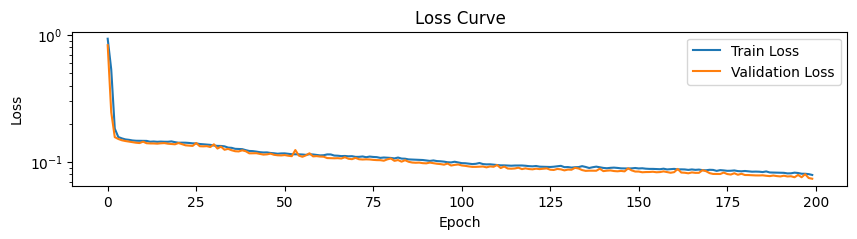

In [9]:
%load_ext autoreload
%autoreload

# Data scaling
x, y, x_offset, x_factor, \
    y_offset, y_factor, scaled_lb, scaled_ub = data_scaling(df, inputs, outputs)
    
# Create and train a ANN
net = create_nn(x, y)

In [10]:
import tensorflow.keras as keras
from omlt import OffsetScaling, OmltBlock
from omlt.io.keras import load_keras_sequential
from omlt.neuralnet import (
    FullSpaceNNFormulation,
    FullSpaceSmoothNNFormulation,
    NetworkDefinition,
    ReducedSpaceSmoothNNFormulation,
    ReluBigMFormulation,
    ReluComplementarityFormulation,
    ReluPartitionFormulation,
)

omlt_model = pyo.ConcreteModel()
omlt_model.cost = OmltBlock()
nn_cost = keras.models.load_model('cost_nn.keras', compile=False)

scaler = OffsetScaling(
    offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
    factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
    offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
    factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))},
)

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

net = load_keras_sequential(
    nn_cost, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds
)
omlt_model.cost.build_formulation(FullSpaceSmoothNNFormulation(net))


In [11]:
# Load ewen basic model
ewen_pyomo_model = ewen_model()

# Create merged model
model = pyo.ConcreteModel()
model.model1 = ewen_pyomo_model
model.model2 = omlt_model

In [12]:
cost = outputs.index('totalcost')

# Create objective function
model.obj = pyo.Objective(expr=model.model1.EFTotal + model.model2.cost.outputs[cost], sense=pyo.minimize)

In [13]:
FiR_1 = inputs.index('Fir1')
FiR_2 = inputs.index('Fir2')
FiR_3 = inputs.index('Fir3')
CiR_1 = inputs.index('Cir1')
CiR_2 = inputs.index('Cir2')
CiR_3 = inputs.index('Cir3')

model.constraint1 = pyo.Constraint(expr=model.model1.FiR[1] == model.model2.cost.inputs[FiR_1])
model.constraint2 = pyo.Constraint(expr=model.model1.FiR[2] == model.model2.cost.inputs[FiR_2])
model.constraint3 = pyo.Constraint(expr=model.model1.FiR[3] == model.model2.cost.inputs[FiR_3])

model.constraint4 = pyo.Constraint(expr=model.model1.CiR[1] == model.model2.cost.inputs[CiR_1])
model.constraint5 = pyo.Constraint(expr=model.model1.CiR[2] == model.model2.cost.inputs[CiR_2])
model.constraint6 = pyo.Constraint(expr=model.model1.CiR[3] == model.model2.cost.inputs[CiR_3])

In [14]:
solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=False)

In [15]:
print(f'EFTotal value: {model.obj()}')
print(f'cost value: {model.model2.cost.outputs[cost].value}')
print(f'ERTotal value: {model.model1.ERTotal()}')
print(f'interc value: {model.model1.interc()}')
print()
print(f'FiR_1 = {model.model1.FiR[1].value}')
print(f'FiR_2 = {model.model1.FiR[2].value}')
print(f'FiR_3 = {model.model1.FiR[3].value}')
print()
print(f'CiR_1 = {model.model1.CiR[1].value}')
print(f'CiR_2 = {model.model1.CiR[2].value}')
print(f'CiR_3 = {model.model1.CiR[3].value}')
print()
print(f'CoR_1 = {model.model1.CoR[1].value}')
print(f'CoR_2 = {model.model1.CoR[2].value}')
print(f'CoR_3 = {model.model1.CoR[3].value}')

EFTotal value: 13136.256827881123
cost value: 12814.79170375777
ERTotal value: 199.9999980000988
interc value: 28.0

FiR_1 = 63.9896863581694
FiR_2 = 94.6675251363237
FiR_3 = 41.342786505605694

CiR_1 = 1066.4947720256414
CiR_2 = 1479.9226374161763
CiR_3 = 413.42786514759626

CoR_1 = 1066.4947720323578
CoR_2 = 946.6752514644635
CoR_3 = 413.4278651561409


__List model constraints__

In [16]:
# Print all constraints of model.model2
for i in model.model2.cost.component_objects(pyo.Constraint, active=True):
    print(f'Constraint: {i}')
    i.pprint()

Constraint: model2.cost._scale_input_constraint
_scale_input_constraint : Size=6, Index=model2.cost.inputs_set, Active=True
    Key : Lower : Body                                                                                          : Upper : Active
      0 :   0.0 :   model2.cost.scaled_inputs[0] - (model2.cost.inputs[0] - 99.0164782439381)/57.17413154295088 :   0.0 :   True
      1 :   0.0 : model2.cost.scaled_inputs[1] - (model2.cost.inputs[1] - 14870.455183543345)/8682.764354206769 :   0.0 :   True
      2 :   0.0 : model2.cost.scaled_inputs[2] - (model2.cost.inputs[2] - 100.4090705170918)/57.539404360536935 :   0.0 :   True
      3 :   0.0 : model2.cost.scaled_inputs[3] - (model2.cost.inputs[3] - 14964.450187900191)/8671.962946884936 :   0.0 :   True
      4 :   0.0 :  model2.cost.scaled_inputs[4] - (model2.cost.inputs[4] - 99.85218703400268)/57.70301524634819 :   0.0 :   True
      5 :   0.0 :  model2.cost.scaled_inputs[5] - (model2.cost.inputs[5] - 14947.51606470589)/8636.744